In [2]:
from keras.layers import Input, Dense, Conv2D, UpSampling2D, MaxPooling2D, Reshape, Flatten, Lambda, Layer, Multiply, Add, GaussianNoise, BatchNormalization
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras import backend as K
from keras import objectives
import numpy as np
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from scipy.stats import norm
import matplotlib.pyplot as plt

#tbc=TensorBoardColab()

Using TensorFlow backend.


#Loading good ol' boring MNIST

Let's pick out the threes alone. We are going to map everything into a 2D latent space, so we won't have much expressive representation power.

Aactually... feel free to pickyour own favourite digit! (just replace the y == digit) in the last couple of rows in the next cell.

In [4]:
MY_FAVOURITE_DIGIT = 9 #@param {type:"integer", min:0, max:9}
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))

x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_train = x_train[y_train==MY_FAVOURITE_DIGIT]
x_test = x_test[y_test==MY_FAVOURITE_DIGIT]

(60000, 784)


#Custom KL divergence layer

There are various ways to implement the KL term of the loss in Keras. I found this to be the cleanest of them all from a software engineering point of view. It's a simple identity layer that comes on top of the z_mean and z_log_sigma of the latent space representation (just after the encoder). It uses the two tensors to compute the KL loss and to add it to the model loss. We are using these means and sigmas to approximate the probability of z using a gaussian function (we will see how we do this a bit later).





In [0]:
class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        kl_batch = - 0.5 * K.sum(1 + z_log_var -
                                K.square(z_mean) -
                                K.exp(z_log_var), axis=-1)
        self.add_loss(K.mean(kl_batch), inputs=inputs)
        return inputs

#Encoder and Decoder definitions

Notie how they're not as deep as in the case of our autoencoder. This is because it's way harder to train a deep VAE than a deep AE. I'm going to let you find out why.

In [0]:
def Encoder(input_shape, latent_dim=64, inter_dim=256):
  input_placeholder = Input(shape=input_shape)
  inter = Dense(inter_dim, activation='relu')(input_placeholder)
  z_mean = Dense(latent_dim, activation='relu')(inter)
  z_log_var = Dense(latent_dim, activation='relu')(inter)
  #split the output into mean and log variance
  return Model(input_placeholder, [z_mean, z_log_var])

def Decoder(output_shape, latent_dim=64, inter_dim=256):
  decoder = Sequential([
      Dense(inter_dim, input_dim=latent_dim, activation='relu'),
      Dense(output_shape[0], activation='sigmoid')
  ])
  return decoder

#Stitching everything together

- note to self: draw architecture on whiteboard

In [0]:
INPUT_SHAPE = (x_train.shape[1],)
LATENT_DIM = 2 #@param {type:"integer"}

encoder = Encoder(input_shape=INPUT_SHAPE, latent_dim=LATENT_DIM)
decoder = Decoder(output_shape=INPUT_SHAPE, latent_dim=LATENT_DIM)
input_placeholder = Input(shape=INPUT_SHAPE)

#Apply KLDivergenceLayer on the encoder output using functional API

z_mean, z_log_var = KLDivergenceLayer()(encoder(input_placeholder))
#We're training the net to estimate the log_var, but for sampling we need sigma
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)
#Define an input that samples from a Gaussian (random normal)
eps = Input(tensor=K.random_normal(shape=(K.shape(input_placeholder)[0], LATENT_DIM)))
#Now shift the mean and mul the variance so that the sample follows our distribution
z_eps = Multiply()([z_sigma,eps])
z = Add()([z_mean, z_eps])
vae = Model([input_placeholder, eps], decoder(z))

In [0]:
def negative_log_likelihood_loss(y, y_pred):
  return K.sum(K.binary_crossentropy(y, y_pred), axis=-1)

vae.compile(optimizer='rmsprop', loss=negative_log_likelihood_loss)

In [0]:
EPOCHS = 50 #@param {type:"integer"}
BATCH_SIZE = 100 #@param {type:"integer"}

vae.fit(x_train, x_train,
        shuffle=True,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(x_test, x_test))

Train on 5949 samples, validate on 1009 samples
Epoch 1/50
5949/5949 [==============================] - 1s 157us/step - loss: 317.5032 - val_loss: 205.6235
Epoch 2/50
5949/5949 [==============================] - 0s 66us/step - loss: 181.6529 - val_loss: 162.0271
Epoch 3/50
5949/5949 [==============================] - 0s 67us/step - loss: 159.5343 - val_loss: 154.5030
Epoch 4/50
5949/5949 [==============================] - 0s 68us/step - loss: 155.3888 - val_loss: 152.4241
Epoch 5/50
5949/5949 [==============================] - 0s 65us/step - loss: 154.3156 - val_loss: 152.2704
Epoch 6/50
5949/5949 [==============================] - 0s 67us/step - loss: 152.8958 - val_loss: 150.4068
Epoch 7/50
5949/5949 [==============================] - 0s 67us/step - loss: 151.7462 - val_loss: 150.2547
Epoch 8/50
5949/5949 [==============================] - 0s 67us/step - loss: 150.9383 - val_loss: 148.7092
Epoch 9/50
5949/5949 [==============================] - 0s 65us/step - loss: 149.9736 - val_los

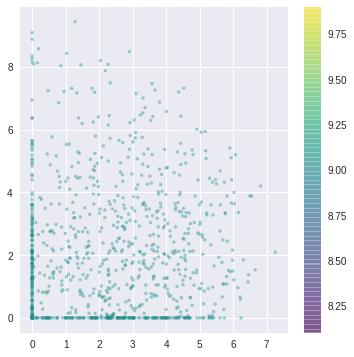

In [0]:
x_test_encoded = encoder.predict(x_test, batch_size=BATCH_SIZE)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test[y_test==MY_FAVOURITE_DIGIT],
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

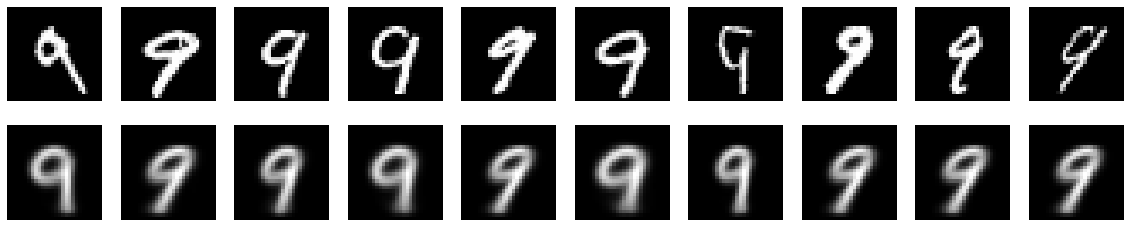

In [0]:
def plot_images(decoded_images, n=10):
  import matplotlib.pyplot as plt

  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()
  
encoded_imgs = encoder.predict(x_test)[0]
decoded_imgs = decoder.predict(encoded_imgs)
plot_images(decoded_imgs)

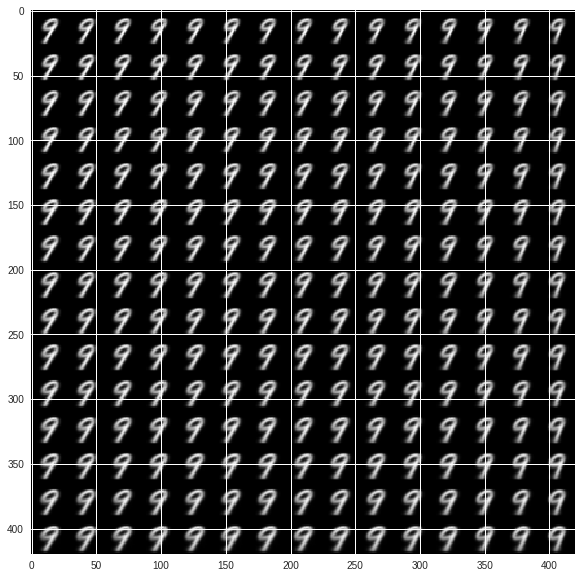

In [0]:
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian
u_grid = np.dstack(np.meshgrid(np.linspace(0.05, 0.95, n),
                               np.linspace(0.05, 0.95, n)))
z_grid = norm.ppf(u_grid)
x_decoded = decoder.predict(z_grid.reshape(n*n, 2))
x_decoded = x_decoded.reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_decoded))), cmap='gray')
plt.show()